In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
class QADataset(Dataset):
  def __init__(self,qa_pairs,question_vocab,answer_vocab,max_length=20):
     self.qa_pairs=qa_pairs
     self.question_vocab=question_vocab
     self.answer_vocab=answer_vocab
     self.max_length=max_length

  def __len__(self):
    return len(self.qa_pairs)

  def __getitem__(self,idx):
    question,answer=self.qa_pairs[idx]

    #convert question to indices
    # Use index 2 for unknown words (UNK token)
    question_indices=[self.question_vocab.word2idx.get(word,2)
    for word in question.lower().split()]

    question_indices.append(2) # Append EOS token (index 2)

    #covert answer to indices
    # Use index 2 for unknown words (UNK token)
    answer_indices=[self.answer_vocab.word2idx.get(word,2)
    for word in answer.lower().split()]
    answer_indices.append(2) # Append EOS token (index 2)


    #pad sequences
    question_padded=question_indices+[0]*(self.max_length-len(question_indices))

    answer_padded=answer_indices+[0]*(self.max_length-len(answer_indices))

    return (torch.tensor(question_padded[:self.max_length]),
          torch.LongTensor(answer_padded[:self.max_length]))

encoder architecture

In [ ]:
class EncoderRNN(nn.Module):
  def __init__(self, hidden_size, vocab_size, embedding_dim, n_layers, dropout=0.1):
    super().__init__()
    self.hidden_size=hidden_size
    self.n_layers=n_layers


    # Embedding layer converts word indices to dense vectors
    self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=0)

    #GRU processes sequences and captures context
    self.gru=nn.GRU(embedding_dim,hidden_size,n_layers,
                    batch_first=True,dropout=dropout if n_layers>1 else 0)


    self.dropout=nn.Dropout(dropout)

  def forward(self,input_seq):
    #input_seq: [batch_size, seq_len]
    embedded=self.dropout(self.embedding(input_seq))
    #embedded: [batch_size, seq_len, embedding_dim]
    outputs,hidden=self.gru(embedded)

    #outputs: [batch_size, seq_len, hidden_size]
    #hidden: [n_layers, batch_size, hidden_size]


    return outputs,hidden

The encoder reads the question word-by-word and produces hidden states. Embedding converts discrete word indices into continuous vectors. GRU (Gated Recurrent Unit) is a type of RNN that captures sequential dependencies. The final hidden state encodes the entire question's meaning.

Bahdanau attention mechanism

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        # Linear layers for attention computation
        self.Wa = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Ua = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Va = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):  # ← Fixed parameter name
        # decoder_hidden: [batch_size, 1, hidden_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]

        # Calculate attention scores
        scores = self.Va(torch.tanh(self.Wa(decoder_hidden) + self.Ua(encoder_outputs)))


        # scores: [batch_size, seq_len, 1]

        # Convert scores to attention weights using softmax
        attention_weights = F.softmax(scores, dim=1)
        # attention_weights: [batch_size, seq_len, 1]

        # Compute context vector as weighted sum of encoder outputs
        context = torch.sum(attention_weights * encoder_outputs, dim=1, keepdim=True)
        # context: [batch_size, 1, hidden_size]

        return context, attention_weights

Attention computes which parts of the question are most relevant when generating each answer word. It calculates attention scores by comparing decoder hidden state with all encoder outputs. Softmax converts scores to attention weights (probability distribution). The context vector is a weighted sum of encoder outputs based on these weights.

decoder with attention

In [ ]:
class AttentionDecoderRNN(nn.Module):
  def __init__(self, vocab_size,embedding_dim ,hidden_size , n_layers=1,dropout=0.1):
    super(AttentionDecoderRNN,self).__init__()
    self.hidden_size=hidden_size
    self.n_layers=n_layers

    self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
    self.attention=BahdanauAttention(hidden_size)

    self.gru=nn.GRU(embedding_dim+hidden_size,hidden_size,n_layers,
                    batch_first=True,dropout=dropout if n_layers>1 else 0)

    self.out=nn.Linear(hidden_size,vocab_size)
    self.dropout=nn.Dropout(dropout)

  def forward(self, input_step,hidden,encoder_outputs):
    # input_step: [batch_size, 1]
    # hidden: [n_layers, batch_size, hidden_size]
    # encoder_outputs: [batch_size, seq_len, hidden_size]

    # Add this print statement to check the shape of hidden
    print("Shape of hidden in AttentionDecoderRNN forward:", hidden.shape)

    # Ensure hidden state has self.n_layers
    if hidden.size(0) < self.n_layers:
        # Replicate the last layer if the number of layers is less than expected
        last_layer_hidden = hidden[-1].unsqueeze(0)
        hidden = last_layer_hidden.repeat(self.n_layers, 1, 1)
    elif hidden.size(0) > self.n_layers:
        # Use only the top self.n_layers if for some reason it has more
        hidden = hidden[-self.n_layers:]


    embedded=self.dropout(self.embedding(input_step))
    # embedded: [batch_size, 1, embedding_dim]

    # Get attention context using top layer hidden state
    query=hidden[-1].unsqueeze(1)
    context,attention_weights =self.attention(query ,encoder_outputs)

    gru_input=torch.cat([embedded,context],dim=2)
    # gru_input: [batch_size, 1, embedding_dim + hidden_size]

    gru_output, hidden = self.gru(gru_input, hidden)
    # gru_output: [batch_size, 1, hidden_size]
    # hidden: [n_layers, batch_size, hidden_size]

    output=self.out(gru_output.squeeze(1))
    # output: [batch_size, vocab_size]

    return output, hidden,attention_weights

The decoder generates the answer word-by-word. At each timestep, it uses attention to focus on relevant question parts. The GRU input combines the previous word embedding and attention context. The output layer projects hidden state to vocabulary size for word prediction

seq2seq model

In [ ]:
class seq2seqQA(nn.Module):
  def __init__(self, encoder, decoder):
    super(seq2seqQA, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, question, answer=None, teacher_forcing_ratio=0.5):
    batch_size = question.size(0)
    # Determine the maximum length for decoding
    # If training with teacher forcing, decode up to the length of the target answer
    if answer is not None and random.random() < teacher_forcing_ratio:
        max_decode_steps = answer.size(1)
    else:
        # Otherwise, decode up to a predefined maximum length (e.g., vocabulary size or a fixed max)
        max_decode_steps = self.decoder.out.out_features # Or a reasonable fixed max length

    # Encode the question
    encoder_outputs, encoder_hidden = self.encoder(question)

    # Add this print statement to check the shape of encoder_hidden
    print("Shape of encoder_hidden in seq2seqQA forward:", encoder_hidden.shape)


    # Initialize decoder
    decoder_hidden = encoder_hidden
    # Use SOS token for initial input
    decoder_input = torch.ones(batch_size, 1, dtype=torch.long, device=device) * self.decoder.embedding.padding_idx + 1 # Assuming SOS is 1

    outputs = []
    attentions = []

    for t in range(max_decode_steps):
      decoder_output, decoder_hidden, attention_weights = \
          self.decoder(decoder_input, decoder_hidden, encoder_outputs) # decoder_hidden is updated here
      # ... (rest of the loop remains the same)
      outputs.append(decoder_output)
      attentions.append(attention_weights)

      if answer is not None and random.random() < teacher_forcing_ratio:
        # Teacher forcing: use actual next token as next input
        # Ensure t is within the bounds of the answer tensor - this check might be redundant now but kept for safety
        if t < answer.size(1):
          decoder_input = answer[:, t].unsqueeze(1)
        else:
          # If teacher forcing but we are beyond answer length (due to max_decode_steps calc), use model prediction
           # This else should ideally not be hit if max_decode_steps is set to answer.size(1)
          decoder_input = decoder_output.argmax(dim=1, keepdim=True)
      else:
        # Without teacher forcing or if teacher forcing is off for this step/index: use predicted next token
        decoder_input = decoder_output.argmax(dim=1, keepdim=True)


    outputs = torch.stack(outputs, dim=1)
    attentions = torch.cat(attentions, dim=1)

    return outputs, attentions

This combines encoder and decoder into a complete seq2seq model. The encoder processes the question first, then the decoder generates the answer. Teacher forcing means sometimes using the actual answer word instead of the prediction during training. This helps the model converge faster but can cause dependency on teacher forcing

if answer is not None and random.random() < teacher_forcing_ratio:: This is the teacher forcing mechanism. If a target answer is provided and a random number is less than teacher_forcing_ratio, the actual next token from the target answer is used as the input for the next time step.
else:: If teacher forcing is not used, the predicted next token (the one with the highest probability from decoder_output) is used as the input for the next time step.

initialize the model

In [ ]:
class vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {0: "<PAD>", 1: "<SOS>", 2: "<UNK>"}
        self.idx = 3  # Start index for new words

        # Add PAD, SOS, and UNK to word2idx
        self.word2idx["<PAD>"] = 0
        self.word2idx["<SOS>"] = 1
        self.word2idx["<UNK>"] = 2


    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

In [ ]:
EMBEDDING_DIM = 256
HIDDEN_SIZE = 528
N_LAYERS = 2
DROPOUT = 0.3
LEARNING_RATE = 0.0001

# Initialize encoder and decoder
encoder = EncoderRNN(
    vocab_size=question_vocab.idx,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

decoder = AttentionDecoderRNN(
    vocab_size=answer_vocab.idx,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

# Create seq2seq model
model = seq2seqQA(encoder, decoder).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Dataset size: {len(qa_pairs)}")

Training function

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0

    for questions, answers in dataloader:
        questions = questions.to(device)
        answers = answers.to(device)

        optimizer.zero_grad()

        # Forward pass with teacher forcing
        outputs, _ = model(questions, answers, teacher_forcing_ratio=0.5)

        # Reshape for loss calculation
        outputs = outputs.view(-1, outputs.size(-1))  # [batch*seq_len, vocab_size]
        answers = answers.view(-1)  # [batch*seq_len]

        # Calculate loss
        loss = criterion(outputs, answers)

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for questions, answers in val_loader:
            questions = questions.to(device)
            answers = answers.to(device)

            # Forward pass without teacher forcing
            outputs, _ = model(questions, answers=None, teacher_forcing_ratio=0)


            outputs_sliced = outputs[:, :answers.size(1), :]

            outputs_sliced_reshaped = outputs_sliced.contiguous().view(-1, outputs_sliced.size(-1))
            answers_reshaped = answers.contiguous().view(-1)

            loss = criterion(outputs_sliced_reshaped, answers_reshaped)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [ ]:
#lets train the model
#loss func and optimizer
criterion=nn.CrossEntropyLoss(ignore_index=0)
optimizer=optim.Adam(model.parameters(),lr=LEARNING_RATE)

N_EPOCHS=50

for epoch in range (N_EPOCHS):
  loss=train_epoch(model,dataloader,optimizer,criterion)

  if (epoch+1)%10==0:
    print(f"epoch [{epoch+1}/{N_EPOCHS}],loss:{loss:.4f}")

print("Training Completed")

Streaming output truncated to the last 5000 lines.
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])
Shape of hidden in AttentionDecoderRNN forward: torch.Size([2, 32, 528])


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

# Load a suitable QA dataset (e.g., SQuAD or a smaller one for demonstration)
# We'll use a smaller dataset for faster loading and experimentation
dataset = load_dataset("squad", split="train[:1000]") # Loading a subset for quicker demonstration

# We need to adapt the dataset to the QADataset class structure (list of question-answer pairs)
qa_pairs = []
for entry in dataset:
    question = entry['question']
    # For SQuAD, there can be multiple answers, we'll take the first one
    answer = entry['answers']['text'][0] if entry['answers']['text'] else ""
    if question and answer: # Ensure both question and answer are not empty
        qa_pairs.append((question, answer))

print(f"Loaded {len(qa_pairs)} question-answer pairs from the dataset")
print("Sample:", qa_pairs[0])

# Build vocabularies
question_vocab = vocabulary()
answer_vocab = vocabulary()

for q, a in qa_pairs:
    # Ensure q and a are treated as strings before splitting
    for word in str(q).lower().split():
        question_vocab.add_word(word)
    for word in str(a).lower().split():
        answer_vocab.add_word(word)


print(f"Question vocabulary size: {question_vocab.idx}")
print(f"Answer vocabulary size: {answer_vocab.idx}")

# Create dataset and dataloader
qa_dataset = QADataset(qa_pairs, question_vocab, answer_vocab, max_length=20)
dataloader = DataLoader(qa_dataset, batch_size=32, shuffle=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Loaded 1000 question-answer pairs from the dataset
Sample: ('To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'Saint Bernadette Soubirous')
Question vocabulary size: 2166
Answer vocabulary size: 1076


In [ ]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train() # Set the model to training mode
    total_loss = 0

    for questions, answers in dataloader:
        questions = questions.to(device)
        answers = answers.to(device)

        optimizer.zero_grad() # Clear gradients

        # Forward pass with teacher forcing
        # outputs shape: [batch_size, max_decode_steps, vocab_size]
        outputs, _ = model(questions, answers, teacher_forcing_ratio=0.5)

        # Slice outputs to match the length of the target answers for loss calculation
        # answers shape: [batch_size, seq_len]
        # outputs_sliced shape: [batch_size, seq_len, vocab_size]
        outputs_sliced = outputs[:, :answers.size(1), :]


        # Reshape output and target for criterion
        # outputs_sliced_reshaped: [batch_size * seq_len, vocab_size]
        # answers_reshaped: [batch_size * seq_len]
        outputs_sliced_reshaped = outputs_sliced.contiguous().view(-1, outputs_sliced.size(-1))
        answers_reshaped = answers.contiguous().view(-1)


        loss = criterion(outputs_sliced_reshaped, answers_reshaped) # Calculate loss

        loss.backward() # Backpropagate
        optimizer.step() # Update weights

        total_loss += loss.item()

    return total_loss / len(dataloader)

inerence function

In [ ]:
def answer_question(model, question, question_vocab, answer_vocab, max_length=15):
    model.eval()

    with torch.no_grad():
        # Tokenize and convert question to indices
        question_indices = [question_vocab.word2idx.get(word, 2) # Use index 2 for UNK
                          for word in question.lower().split()]
        question_indices.append(2)  # EOS (Use index 2 for EOS based on vocabulary definition)

        # Pad question
        question_padded = question_indices + [0] * (max_length - len(question_indices))
        question_tensor = torch.LongTensor(question_padded[:max_length]).unsqueeze(0).to(device)

        # Generate answer
        outputs, attentions = model(question_tensor, answer=None, teacher_forcing_ratio=0)

        # Decode output indices to words
        predicted_indices = outputs.argmax(dim=2).squeeze(0)
        answer_words = []

        for idx in predicted_indices:
            if idx.item() == 2:  # EOS token (Use index 2 for EOS)
                break
            word = answer_vocab.idx2word.get(idx.item(), "<UNK>")
            if word not in ["<PAD>", "<SOS>"]: # Exclude PAD and SOS from output
                answer_words.append(word)

        return " ".join(answer_words), attentions

test the model

In [ ]:
# Test with training examples
test_questions = [
    "what is your name",
    "how are you",
    "what is ai",
    "what can you do"
]

print("Testing Question Answering Model:\n")
for question in test_questions:
    answer, attention = answer_question(model, question, question_vocab, answer_vocab)
    print(f"Q: {question}")
    print(f"A: {answer}\n")


Testing Question Answering Model:

Q: what is your name
A: my is is assistant

Q: how are you
A: i am fine

Q: what is ai
A: my is artificial intelligence

Q: what can you do
A: i can answer questions



Q: what is your name
A: my is is assistant



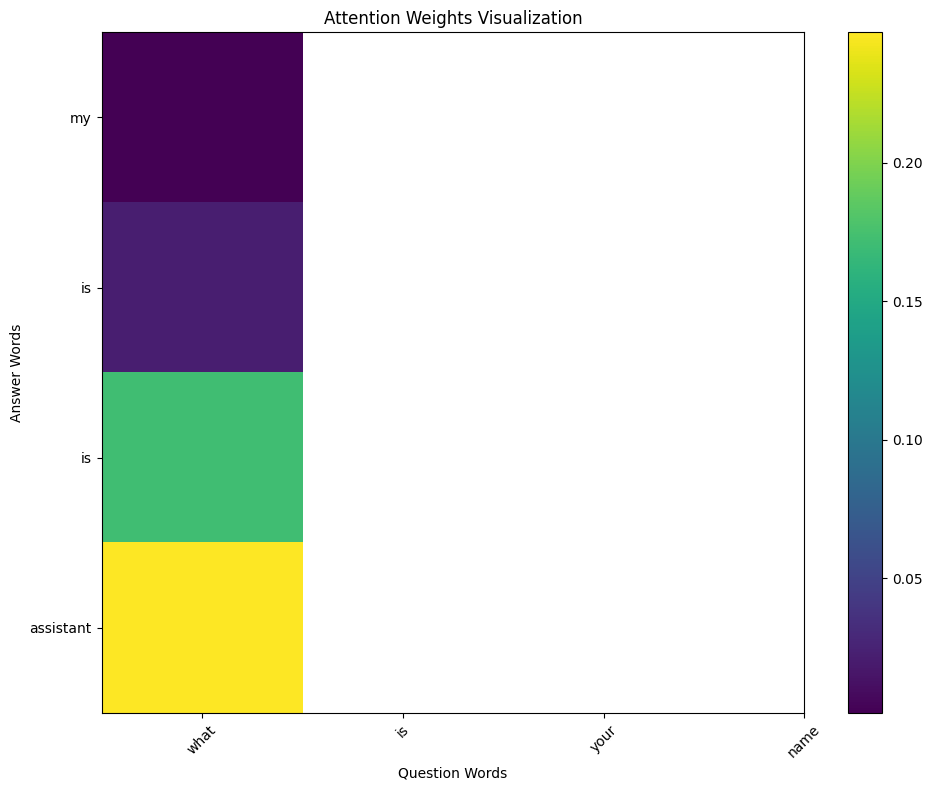

In [ ]:
#visualize attention weights
import matplotlib.pyplot as plt

def visualize_attention(question, answer, attention_weights, question_vocab):
    # Convert question to words
    question_words = question.lower().split()
    answer_words = answer.split()

    # Get attention for answer length
    attn = attention_weights[0, :len(answer_words), :len(question_words)].cpu().numpy()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(attn, cmap='viridis', aspect='auto')
    plt.colorbar()

    plt.xticks(range(len(question_words)), question_words, rotation=45)
    plt.yticks(range(len(answer_words)), answer_words)
    plt.xlabel('Question Words')
    plt.ylabel('Answer Words')
    plt.title('Attention Weights Visualization')
    plt.tight_layout()
    plt.show()

# Visualize attention for a question
question = "what is your name"
answer, attention = answer_question(model, question, question_vocab, answer_vocab)
print(f"Q: {question}\nA: {answer}\n")
visualize_attention(question, answer, attention, question_vocab)
